<a href="https://colab.research.google.com/github/MarciaGodoy/decisiontree/blob/main/XGBoost_Classifica%C3%A7%C3%A3o2022.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning aplicado à Saude


---




# Parte II - Classificação: XGBoost

#### Instalando e importando bibliotecas necessárias

In [1]:
!pip install dfply >> /dev/null
!pip install shap >> /dev/null 
!pip install boruta >> /dev/null 

In [2]:
import pandas as pd # para processamento de bancos de dados
import numpy as np # para processamento numérico de bancos de dados
from dfply import *  # para importar os comandos da biblioteca dfply
import shap  # para a visualização da importância das variáveis para o modelo
import matplotlib.pyplot as plt # para geração de gráficos
from matplotlib import rc  # configurações adicionais para os gráficos a serem gerados

# informamos ao Python que estamos usando um notebook e que os gráficos devem ser exibidos nele
%matplotlib inline   
import seaborn as sns #alternativa para a matplotlib para geração de gráficos

# definimos o estilo dos gráficos
# mais estilos em https://matplotlib.org/3.1.1/gallery/#style-sheets
plt.style.use("fivethirtyeight") 
%config InlineBackend.figure_format = 'retina' # formato das imagens
rc('font',**{'family':'sans-serif','sans-serif':['DejaVu Sans'],'size':10}) #fonte utilizada
rc('mathtext',**{'default':'regular'})

import warnings   # ignorando os warnings emitidos pelo Python
warnings.filterwarnings("ignore")

np.random.seed(42)  # semente de aleatoriedade que garante a replicabilidade 

from sklearn.model_selection import train_test_split  # importamos a funcionalidade de split do conjunto de dados em treino/teste
from sklearn.preprocessing import StandardScaler  # para padronização dos dados
from sklearn.model_selection import RandomizedSearchCV # para otimização dos hiperparâmetros

# métricas de performance para modelos de classificação
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
from sklearn.metrics import brier_score_loss, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import KFold, cross_val_score

# para evitarmos a exibição dos dados em notação científica
pd.set_option('display.float_format', lambda x: '%.2f' % x)

#### Importando o conjunto de dados como um Pandas DataFrame

Informações sobre a construção desse banco de dados:
https://www.biorxiv.org/content/10.1101/232611v1

In [3]:
# Synthetic Cardiovascular Risk Dataset
df = pd.read_csv('https://raw.githubusercontent.com/laderast/cvdRiskData/master/data-raw/fullPatientData.csv', sep=",")  # abrindo o arquivo csv que possui separador de colunas por vírgula
print('Entrada de dados executada')

Entrada de dados executada


#### Verificação inicial do banco de dados

In [4]:
# Número de observações e colunas
df.shape

(425195, 13)

In [5]:
# Número de observações de desfecho
df['cvd'].value_counts()

N    375325
Y     49870
Name: cvd, dtype: int64

In [6]:
df.head()

,patientID,age,htn,treat,smoking,race,t2d,gender,numAge,bmi,tchol,sbp,cvd
0,HHUID00076230,20-40,Y,Y,N,Asian/PI,N,M,21,26,176,179,N
1,HHUID00547835,70-90,N,N,N,White,N,M,86,23,244,123,N
2,HHUID00450841,20-40,Y,Y,N,White,N,M,29,22,189,165,N
3,HHUID00380788,20-40,Y,Y,N,White,N,M,24,24,218,172,N
4,HHUID00043423,20-40,N,N,N,Asian/PI,N,M,40,20,207,111,N


In [7]:
# Dicionário de variáveis em: https://github.com/laderast/cvdNight2/blob/master/data/dataDictionary.pdf

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 425195 entries, 0 to 425194
Data columns (total 13 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   patientID  425195 non-null  object
 1   age        425195 non-null  object
 2   htn        425195 non-null  object
 3   treat      425195 non-null  object
 4   smoking    425195 non-null  object
 5   race       425195 non-null  object
 6   t2d        425195 non-null  object
 7   gender     425195 non-null  object
 8   numAge     425195 non-null  int64 
 9   bmi        425195 non-null  int64 
 10  tchol      425195 non-null  int64 
 11  sbp        425195 non-null  int64 
 12  cvd        425195 non-null  object
dtypes: int64(4), object(9)
memory usage: 42.2+ MB


In [9]:
# vemos se ha registros duplicados
any(df['patientID'].duplicated()) 

False

#### Filtrando e limpando o banco de dados 

In [10]:
# consideramos indivíduos com idade superior a 55 anos. Removeremos também as variáveis "patientID", "age" e "treat"
df = (df >>
            mask(X.numAge > 55) >>
            drop(X.patientID, X.age, X.treat)
            )

In [11]:
# Número de observações pós filtro
df.shape

(125335, 10)

In [12]:
# Número de observações de desfecho pós filtro
df['cvd'].value_counts()

N    90108
Y    35227
Name: cvd, dtype: int64

In [13]:
# Resumo estatístico das variáveis numéricas
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
numAge,125335.00,68.14,9.32,56.00,61.00,66.00,74.00,90.00
bmi,125335.00,21.91,4.40,15.00,19.00,21.00,24.00,36.00
tchol,125335.00,188.38,29.61,155.00,160.00,181.00,209.00,245.00
sbp,125335.00,148.21,31.64,77.00,119.00,138.00,179.00,221.00


In [14]:
# criamos dummies para variáveis categóricas 
df = pd.get_dummies(df, columns=['htn', 'smoking', 't2d', 'gender', 'race'], dtype=int)

In [15]:
# mantemos apenas uma dummy como referência quando apenas duas categorias 
df.drop(['htn_N', 'smoking_N','t2d_N','gender_F'], axis=1, inplace=True)

In [16]:
# transformando o desfecho em numérico
df.cvd = df['cvd'].replace('Y', '1', regex=True)
df.cvd = df['cvd'].replace('N', '0', regex=True)
df['cvd'].value_counts()

0    90108
1    35227
Name: cvd, dtype: int64

#### Divisão dos conjuntos de dados 70% para treino e 30% para teste

In [17]:
# separando as variáveis preditoras do desfecho
preditoras = df.iloc[:, df.columns != 'cvd']
desfecho = df.iloc[:, df.columns == 'cvd']

In [18]:
# separando os conjuntos de treino e de teste
X_train, X_test, y_train, y_test = train_test_split(preditoras, desfecho, test_size=.30, random_state=42)

In [19]:
X_train.shape
print('Linhas e colunas preditoras no treino:',X_train.shape)

X_test.shape
print('Linhas e colunas preditoras no teste:',X_test.shape)

y_train.shape
print('Linhas e coluna desfecho no treino:',y_train.shape)

y_test.shape
print('Linhas e coluna desfecho no teste:',y_test.shape)

Linhas e colunas preditoras no treino: (87734, 12)
Linhas e colunas preditoras no teste: (37601, 12)
Linhas e coluna desfecho no treino: (87734, 1)
Linhas e coluna desfecho no teste: (37601, 1)


In [20]:
# verificação da existência de variáveis constantes 
constant_features = [
    feat for feat in X_train.columns if X_train[feat].std() == 0
]
constant_features

[]

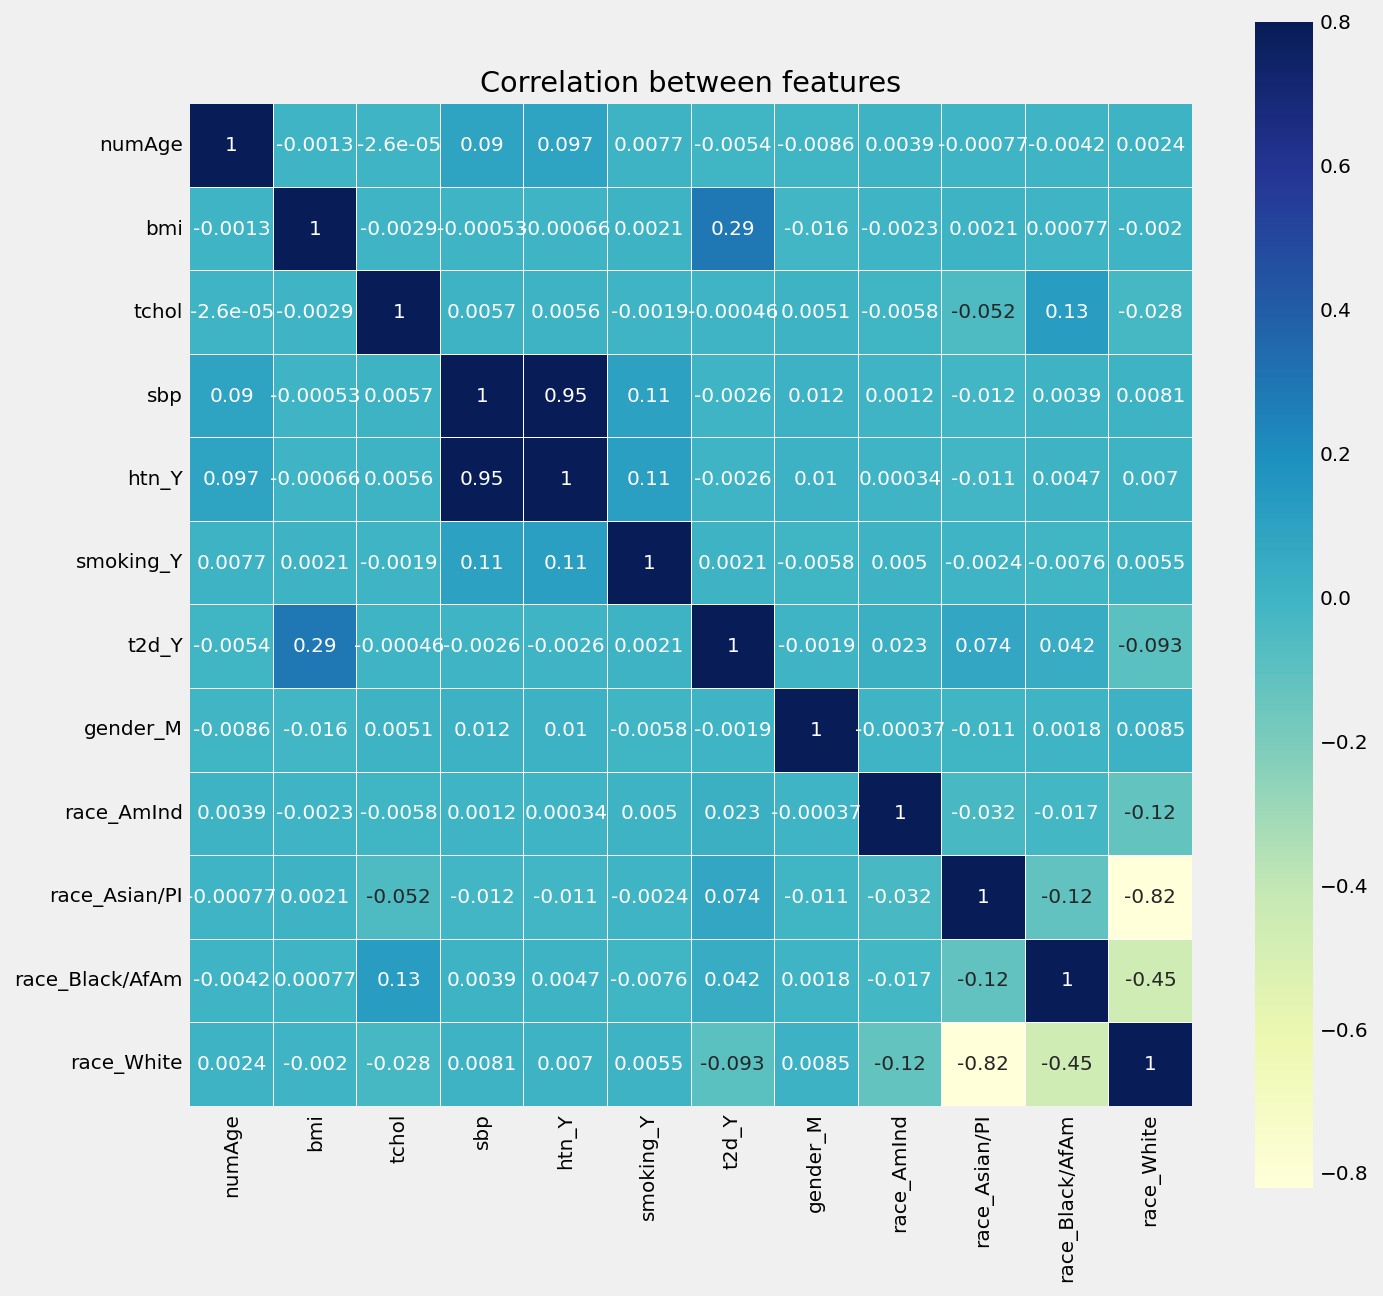

In [21]:
# verificando a correlação entre as variáveis

# método de Pearson
corr=X_train.corr(method='pearson')
plt.figure(figsize=(10, 10)) 
sns.heatmap(corr, vmax=.8, linewidths=0.01,
          square=True,annot=True,cmap='YlGnBu',linecolor="white")
plt.title('Correlation between features')
plt.show()

In [22]:
# retirando a variável com correlação acima de 0.9
X_train.drop(['htn_Y'], axis=1, inplace=True)
X_test.drop(['htn_Y'], axis=1, inplace=True)

In [23]:
# padronização
continuas_cols = df.iloc[:, df.columns.isin(['numAge', 'bmi', 'tchol', 'sbp'])]
categoricas_cols = df.iloc[:, ~df.columns.isin(['numAge', 'bmi', 'tchol', 'sbp'])]

# padronização de dados (fit_transform armazena a média e dp para usar no conjunto de teste) 
sc = StandardScaler()
X_train[continuas_cols.columns] = sc.fit_transform(X_train[continuas_cols.columns])
X_test[continuas_cols.columns] = sc.transform(X_test[continuas_cols.columns]) # padronização dos dados de teste

#### Execução de algoritmo de machine learning

In [24]:
# importando o XGBoost
from xgboost import XGBClassifier

In [25]:
# modelo XGBoost
xgb = XGBClassifier(random_state=42,verbose=1)

In [27]:
np.random.seed(42)

# definindo o espaço de hiperparâmetros
param_grid = {"learning_rate": np.arange(0, 1, 0.01), 
              "n_estimators": np.arange(10, 500, 20),
              "subsample": [0.1, 0.2, 0.3, 0.5, 0.7, 0.9, 1],
              "max_depth": [int(x) for x in np.linspace(10, 110, num=11)],  
              "colsample_bytree": [0.5, 0.7, 0.9, 1],
              "min_child_weight": [1, 2, 3, 4]
              }

xgb_cv = RandomizedSearchCV(xgb, param_distributions=param_grid, scoring='roc_auc', n_jobs = -1, cv=3, n_iter=30) 

In [ ]:
# otimizando os hiperparâmetros
xgb_cv = xgb_cv.fit(X_train, y_train)

In [ ]:
# resultados da busca 
print('Melhor score: %s' % xgb_cv.best_score_)
print('Melhores hiperparâmetros: %s' % xgb_cv.best_params_)

In [ ]:
# selecionando apenas os resultados da busca
xgb = XGBClassifier(subsample= 0.3, 
                    n_estimators= 150, 
                    min_child_weight=3, 
                    max_depth= 30, 
                    learning_rate= 0.02, 
                    colsample_bytree= 0.7,
                    random_state=42)

# treinando o modelo otimizado
xgb.fit(X_train, y_train)

In [ ]:
# realizando as predições do  modelo
y_pred = xgb.predict(X_test)

In [ ]:
# Demais métricas
prob_pos = xgb.predict_proba(X_test)
prob_pos = prob_pos[:,1]
print("\tROC(AUC) %1.2f" % roc_auc_score(y_test, prob_pos))

# relatório de classificação
cr = classification_report(y_test, y_pred)
print(cr)

In [ ]:
# matriz de confusão
mc = confusion_matrix(y_test, y_pred)
print(mc)

In [ ]:
# importância de variáveis com SHAP
explainer = shap.Explainer(xgb, X_test)
shap_values = explainer(X_test, check_additivity=False)
shap.summary_plot(shap_values, X_test)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy
# seleção de variáveis com o Boruta
# inicializa o Random Forest para o Boruta (max_depth de 3 a 7 segundo o github do Boruta)
rf_boruta = RandomForestClassifier(n_jobs=-1, random_state=42, max_depth=5)

# define o Boruta como método de seleção de variáveis
boruta = BorutaPy(estimator = rf_boruta, n_estimators = 'auto', verbose=2, random_state=42, max_iter = 100)

# fit Boruta 
boruta.fit(np.array(preditoras), np.array(desfecho))

# mostrando os resultados
area_verde = preditoras.columns[boruta.support_].to_list()
area_azul = preditoras.columns[boruta.support_weak_].to_list()

# manter
print('Variáveis na área verde:', area_verde) 

# inconclusivo 
print('Variáveis na área azul:', area_azul)   

print('Ranking: ', boruta.ranking_)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	12
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	11
Tentative: 	0
Rejected: 	1


BorutaPy finished running.

Iteration: 	9 / 100
Confirmed: 	11
Tentative: 	0
Rejected: 	1
Variáveis na área verde: ['numAge', 'bmi', 'tchol', 'sbp', 'htn_Y', 'smoking_Y', 't2d_Y', 'gender_M', 'race_Asian/PI', 'race_Black/AfAm', 'race_White']
Variáveis na área azul: []
Ranking:  [1 1 1 1 1 1 1 1 2 1 1 1]


#### Modelo com o Boruta 

In [ ]:
# removendo as variáveis não selecionadas pelo Boruta  
X_train.drop(['race_AmInd'], axis=1, inplace=True)
X_test.drop(['race_AmInd'], axis=1, inplace=True)

In [ ]:
# selecionando apenas os resultados da busca
xgb_boruta = XGBClassifier(subsample= 0.3, 
                        n_estimators= 150, 
                        min_child_weight=3, 
                        max_depth= 30, 
                        learning_rate= 0.02, 
                        colsample_bytree= 0.7,
                        random_state=42)

# treinando o modelo otimizado
xgb_boruta.fit(X_train, y_train)

XGBClassifier(colsample_bytree=0.7, learning_rate=0.02, max_depth=30,
              min_child_weight=3, n_estimators=150, random_state=42,
              subsample=0.3)

In [ ]:
# Demais métricas
prob_pos = xgb_boruta.predict_proba(X_test)
prob_pos = prob_pos[:,1]
print("\tROC(AUC) %1.2f" % roc_auc_score(y_test, prob_pos))

	ROC(AUC) 0.77


---